<a href="https://colab.research.google.com/github/17092003vamsi/guner/blob/main/cnn_code_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.5987 - loss: 1.2092 - val_accuracy: 0.7966 - val_loss: nan - learning_rate: 0.0010
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 735ms/step - accuracy: 0.8432 - loss: 0.4313 - val_accuracy: 0.8814 - val_loss: nan - learning_rate: 0.0010
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 717ms/step - accuracy: 0.8729 - loss: 0.2365 - val_accuracy: 0.8644 - val_loss: nan - learning_rate: 0.0010
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.9123 - loss: 0.2449 - val_accuracy: 0.9153 - val_loss: nan - learning_rate: 0.0010
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 706ms/step - accuracy: 0.9198 - loss: 0.2048 - val_accuracy: 0.8475 - val_loss: nan - learning_rate: 0.0010
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.9533 - loss: 0.1408 - val_accuracy: 0.8475 - val_loss: nan - learning_rate: 2.0000e-04
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 736ms/step - accuracy: 0.9767 - loss: 0.1175 - val_accuracy: 0.8814 - val_loss: nan

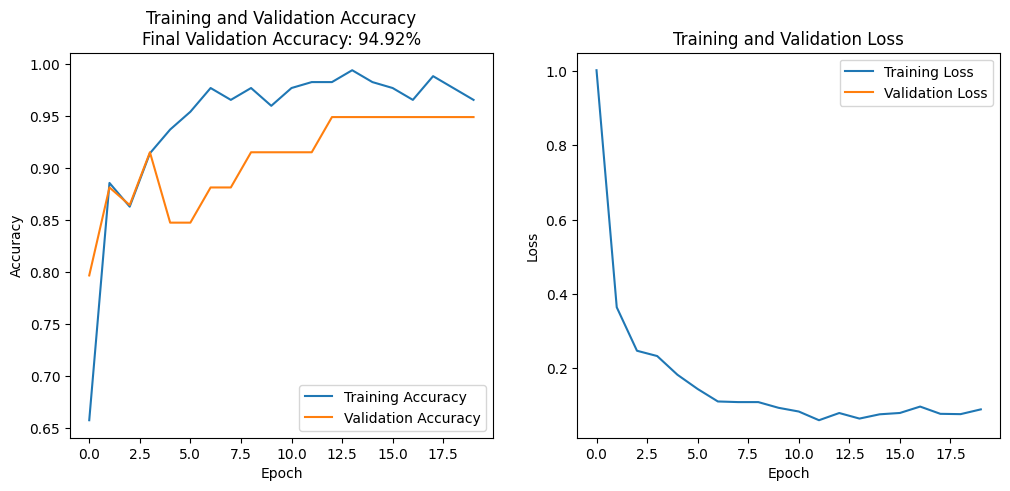

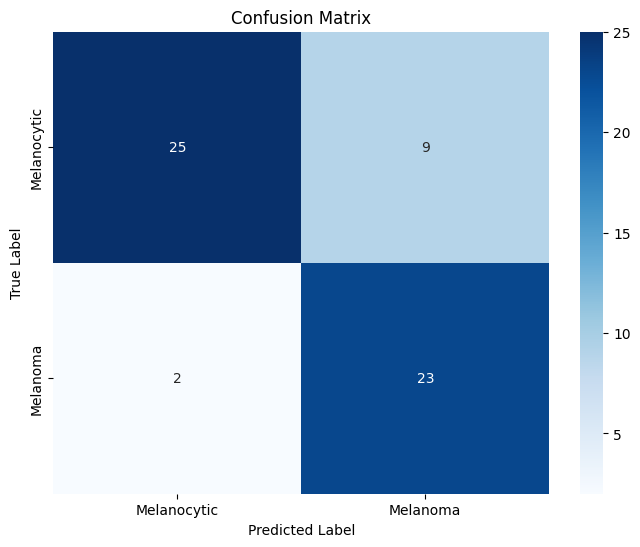

/usr/local/lib/python3.10/dist-packages/shap/explainers/_deep/deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")


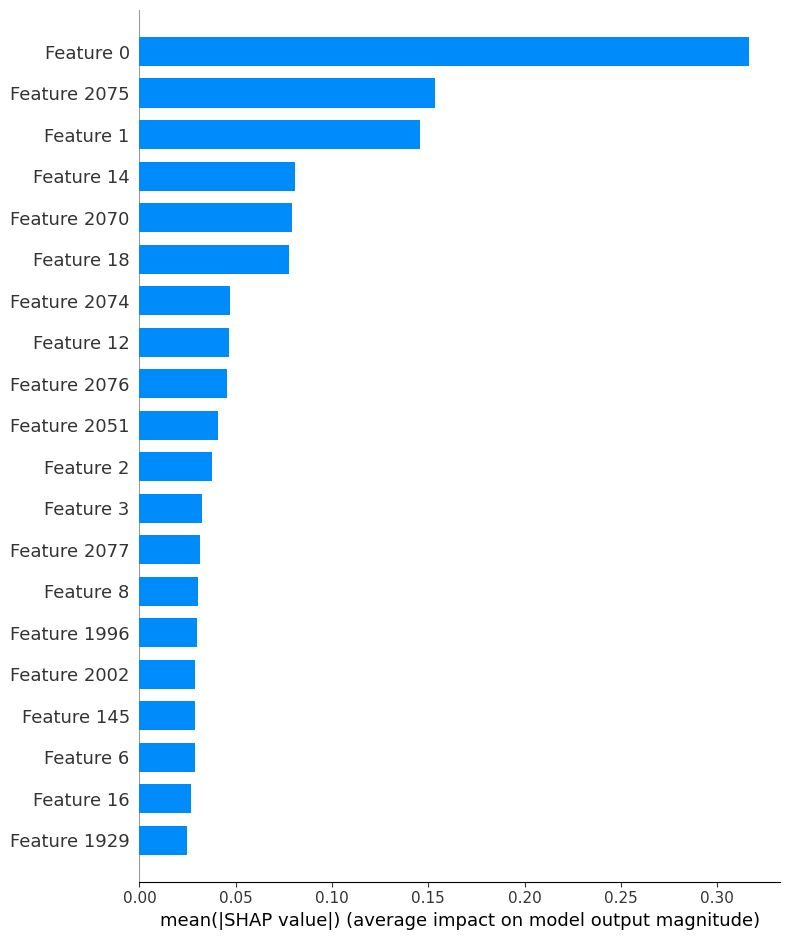

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Predicted class for the new signal: Melanoma


In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.fft import fft
import shap

# Load the dataset
def load_data(file_path):
    data = pd.read_csv(file_path)
    return data

# Preprocess the data
def preprocess_data(data):
    # Encode labels
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(data['Lable'].values)

    # Select all feature columns (assuming they are columns 0 to 2088)
    feature_cols = [str(i) for i in range(2089)]
    X = data[feature_cols].values

    # Apply FFT to each signal in the feature matrix
    X_fft = np.abs(np.array([fft(signal) for signal in X]))

    # Reshape for CNN input
    X_fft = X_fft.reshape((X_fft.shape[0], X_fft.shape[1], 1))

    return X_fft, y

# Split the dataset into training, validation, and testing sets
def split_data(X, y):
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)
    return X_train, X_val, X_test, y_train, y_val, y_test

# Build the CNN model
def build_model(input_shape):
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.25),

        Conv1D(128, kernel_size=3, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.25),

        Conv1D(256, kernel_size=3, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.25),

        Flatten(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),

        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Train the model with callbacks
def train_model(model, X_train, y_train, X_val, y_val):
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

    history = model.fit(X_train, y_train, epochs=20, batch_size=32,
                        validation_data=(X_val, y_val),
                        callbacks=[early_stopping, reduce_lr])
    return history

# Evaluate the model
def evaluate_model(model, X_test, y_test):
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

    y_pred = (model.predict(X_test) > 0.5).astype("int64")
    cm = confusion_matrix(y_test, y_pred)

    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    return cm, test_accuracy

# Visualize results
def plot_results(history, cm, val_accuracy):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'Training and Validation Accuracy\nFinal Validation Accuracy: {val_accuracy*100:.2f}%')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Melanocytic", "Melanoma"], yticklabels=["Melanocytic", "Melanoma"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# SHAP model explainability
def explain_model(model, X_test):
    # Select a smaller subset of test data for explanation
    subset_size = 100
    X_test_subset = X_test[:subset_size]

    # Ensure the SHAP explainer matches the input shape of the model
    explainer = shap.DeepExplainer(model, X_test_subset)
    shap_values = explainer.shap_values(X_test_subset)

    # Handle the case where shap_values is a list (for multi-output models)
    if isinstance(shap_values, list):
        shap_values = shap_values[0]  # Select the first output's SHAP values

    # Reshape SHAP values to match the original input shape
    shap_values_reshaped = shap_values.reshape(shap_values.shape[0], -1)

    # Reshape X_test_subset for compatibility with summary_plot
    X_test_subset_reshaped = X_test_subset.reshape(X_test_subset.shape[0], -1)

    # Plot summary using SHAP mean absolute values
    shap.summary_plot(shap_values_reshaped, X_test_subset_reshaped, plot_type="bar")


# Predict a single sample
def predict_single_sample(model, X_val):
    new_signal = X_val[0].reshape(1, -1, 1)
    prediction = model.predict(new_signal)
    predicted_class = "Melanocytic" if prediction < 0.5 else "Melanoma"
    print(f"Predicted class for the new signal: {predicted_class}")

# Main execution
def main():
    file_path = 'project 2 sap.csv'
    data = load_data(file_path)
    X, y = preprocess_data(data)
    X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y)

    model = build_model((X_train.shape[1], 1))
    history = train_model(model, X_train, y_train, X_val, y_val)

    val_accuracy = history.history['val_accuracy'][-1]

    cm, test_accuracy = evaluate_model(model, X_test, y_test)

    print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
    print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

    plot_results(history, cm, val_accuracy)
    explain_model(model, X_test)
    predict_single_sample(model, X_val)

# Run the main function
main()
